In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml
import ast

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

# Read yaml config and data

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
NUMERIC_FIELD_INFO = yaml_data['convert_obj_numeric']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']

In [5]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [6]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

# Preprocessing

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

In [8]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [9]:
# Replace all np.nan to None
dp.replace_nan_none()

In [10]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [11]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [12]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [13]:
# Convert fields from Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [14]:
# Convert fields from Object to Numeric 
dp.numeric_conversion(NUMERIC_FIELD_INFO)

hello i am here


In [15]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [16]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [17]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [18]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [19]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [20]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

In [21]:
# Get Dataframe
df_cruise = dp.get_dataframe()

# Feature Engineering

In [22]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82634 entries, 3 to 133745
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      82634 non-null  int32  
 1   Onboard Wifi Service                        82634 non-null  int32  
 2   Embarkation/Disembarkation time convenient  69338 non-null  object 
 3   Ease of Online booking                      68164 non-null  object 
 4   Gate location                               71979 non-null  object 
 5   Onboard Dining Service                      82634 non-null  int32  
 6   Online Check-in                             71227 non-null  object 
 7   Cabin Comfort                               70096 non-null  object 
 8   Onboard Entertainment                       82634 non-null  int32  
 9   Cabin service                               74097 non-null  object 
 10  Baggage handli

In [23]:
fe = feature_engineering(df_cruise)

In [24]:
# Standardise distance by converting Mile to KM
fe.convert_miles_to_KM("Distance")

In [25]:
# Derive Age from Year of Birth and Year of Logging
fe.calc_year_diff('Year of Logging', 'Year of Birth', 'Age')

In [26]:
# Compute number of column
fe.denote_missing_col()

['Embarkation/Disembarkation time convenient_missing', 'Ease of Online booking_missing', 'Gate location_missing', 'Online Check-in_missing', 'Cabin Comfort_missing', 'Cabin service_missing', 'Baggage handling_missing', 'Port Check-in Service_missing', 'Onboard Service_missing', 'Cleanliness_missing']


#### Gender

In [27]:
fe.impute_missing_value(impute_type="random", col_list=['Gender'], none_val=2)

In [29]:
fe.impute_missing_value(impute_type="mean")

# Model Building

In [31]:
X = df_cruise.drop([TARGET_VARIABLE],axis=1)
y = df_cruise[TARGET_VARIABLE]

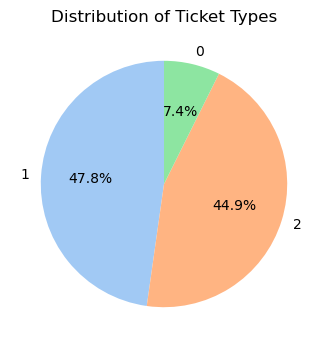

In [32]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [33]:
# Perform SMOTE
X, y = fe.SMOTE(X, y, RANDOM_STATE)

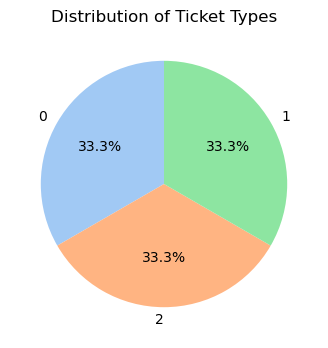

In [34]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE , random_state=RANDOM_STATE)
y_train = y_train.values.ravel()

In [36]:
log_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
log_regression.fit(X_train, y_train)
y_train_pred_log = log_regression.predict(X_train)
y_test_pred_log = log_regression.predict(X_test)

In [38]:
# random_forest = RandomForestClassifier()
# random_forest.fit(X_train, y_train)
# y_train_pred_rf = random_forest.predict(X_train)
# y_test_pred_rf = random_forest.predict(X_test)

# Model Evaluation

In [37]:
from sklearn import metrics
print("Classification report - Train")
print(classification_report(y_train, y_train_pred_log))
print("Classification report - Test")
print(classification_report(y_test, y_test_pred_log))
print(" ")
print("Classification report - Test")
print(confusion_matrix(y_train, y_train_pred_log))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_log))
print(" ")
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
# print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# print(" ")
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
# print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

print("")


Classification report - Train
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     31600
           1       0.73      0.68      0.70     31501
           2       0.61      0.54      0.57     31624

    accuracy                           0.64     94725
   macro avg       0.65      0.64      0.64     94725
weighted avg       0.65      0.64      0.64     94725

Classification report - Test
              precision    recall  f1-score   support

           0       0.60      0.72      0.65      7869
           1       0.73      0.66      0.70      7968
           2       0.60      0.54      0.57      7845

    accuracy                           0.64     23682
   macro avg       0.64      0.64      0.64     23682
weighted avg       0.64      0.64      0.64     23682

 
Classification report - Test
[[22612  3274  5714]
 [ 4851 21270  5380]
 [ 9771  4724 17129]]
Confusion Matrix - Test
[[5656  837 1376]
 [1235 5298 1435]
 [2514 1127 4204]]
 
Tra

In [39]:
# from sklearn import metrics
# print("Classification report - Train")
# print(classification_report(y_train, y_train_pred_rf))
# print("Classification report - Test")
# print(classification_report(y_test, y_test_pred_rf))
# print(" ")
# print("Classification report - Test")
# print(confusion_matrix(y_train, y_train_pred_rf))
# print("Confusion Matrix - Test")
# print(confusion_matrix(y_test, y_test_pred_rf))
# print(" ")
# print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_rf), '.4f'))
# # print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# # print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# # print(" ")
# print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_rf), '.4f'))
# # print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# # print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

# print("")


Classification report - Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31600
           1       1.00      1.00      1.00     31501
           2       1.00      1.00      1.00     31624

    accuracy                           1.00     94725
   macro avg       1.00      1.00      1.00     94725
weighted avg       1.00      1.00      1.00     94725

Classification report - Test
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7869
           1       0.90      0.86      0.88      7968
           2       0.76      0.86      0.81      7845

    accuracy                           0.86     23682
   macro avg       0.86      0.86      0.86     23682
weighted avg       0.86      0.86      0.86     23682

 
Classification report - Test
[[31600     0     0]
 [    0 31501     0]
 [    0     0 31624]]
Confusion Matrix - Test
[[6693  154 1022]
 [  24 6832 1112]
 [ 446  645 6754]]
 
Tra